### Import Statements

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [4]:
%matplotlib inline

## **Input from Mouse**

### *Mouse events* ([Documentation](https://docs.opencv.org/4.x/d0/d90/group__highgui__window__flags.html#gaab4dc057947f70058c80626c9f1c25ce))

Mouse event can be anything related to mouse like left-button down, left-button up, left-button double-click etc.

In [5]:
# list of all the available mouse event types and flags

mouse_events = [func for func in dir(cv) if func.startswith("EVENT")]

> The `cv.setMouseCallback(winname, onMouse, userdata = 0)` function is used to **call a specific function (onMouse) when any mouse event takes place on a specific window (winname)**.

This function monitors a specific window for mouse events (see the docs for the available mouse event flags and types). When a mouse event takes place it calls the callback function with the event type and the event coordinates (x,y).

<u>Function Parameters:</u>
- winname: Name of the window which is observed for any mouse event.
- onMouse: Callback function for mouse events.
- userdata: The optional parameter passed to the callback function. 

> Defining the `callback function`

The callback function has a specific format as to what argument it takes. The function can vary widely about what it does with the inputs but the inputs are to be provided in a specific sequence and format.

The callback function takes 5 arguments. A demo of such a function is provided below,

    def onMouse(event, x, y, flags, userdata):
        # function body
        return something

<u>Function Parameters</u>

- event: **one** of the cv MouseEventTypes constants.
- x: The x-coordinate of the mouse event.
- y: The y-coordinate of the mouse event.
- flags: **one** of the cv MouseEventFlags constants.
- userdata:	The optional parameter. 

**`Note:`** We don't need to provide any onMouse function parameter values when calling, the setMouseCallback will do that when it calls the onMouse callback function.

> So, the whole process goes as follows,

1. First we create a callback function
2. Next we choose which window we want to bind that function to
3. Finally we bind the chosen window to the callback function using cv.setMouseCallback()

##### Here we have a simple callback function that can be used to record mouse movements while the left mouse button is held down. The recording is initiated when the left mouse button is double clicked and ends when the left mouse button is released.

In [24]:
def simple_callback(event, x, y, flags, userdata):
    # we need to use global variables otherwise everytime a mouse event occurs, the variables will be initialized
    # a new and the last state won't be saved.

    # That's why if we define "is_left_down = False" inside the function block the mouse movements will not be
    # captured since in case of a mouse event where the mouse moves, the is_left_down will always be false.

    # is_left_down = False

    global is_left_down, mouseX_mouseY

    # double clicking the left button is a preliminary requirement for the mouse movements to be stored in an array
    if event == cv.EVENT_LBUTTONDBLCLK:
        is_left_down = True
        print(f"Left button double clicked at: {(x, y)}")

    if event == cv.EVENT_LBUTTONUP:
        is_left_down = False
        print(f"Left button click released at: {x, y}")

    if is_left_down is True and event == cv.EVENT_MOUSEMOVE:
        mouseX_mouseY.append((x, y))

    return mouseX_mouseY

In [25]:
# global variables that would be used in the callback function
# we define them here because otherwise the variables will have values from the previous run instead of being
# initialized a new.
is_left_down = False
mouseX_mouseY = []

# defining the window to track and setting mouse callback
img = np.zeros((640, 480), dtype=np.uint8)
cv.namedWindow("image")
cv.setMouseCallback("image", simple_callback)

# showing the window
while True:
    cv.imshow("image", img)
    keyboad_input = cv.waitKey(1000)
    if keyboad_input == ord("q"):
        break

cv.destroyAllWindows()

Left button click released at: (165, 287)
Left button double clicked at: (165, 287)
Left button click released at: (320, 279)
Left button click released at: (195, 224)
Left button double clicked at: (195, 224)
Left button click released at: (182, 227)
Left button click released at: (273, 241)
Left button double clicked at: (273, 241)
Left button click released at: (266, 239)


In [26]:
pts = np.array(mouseX_mouseY, dtype=np.int32)

In [27]:
pts.shape

(437, 2)

In [28]:
pts = pts.reshape(pts.shape[0], 1, 2)

In [29]:
canvas = img.copy().astype(np.uint8)

In [30]:
cv.polylines(canvas, [pts], isClosed=False, color=(200), thickness=2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

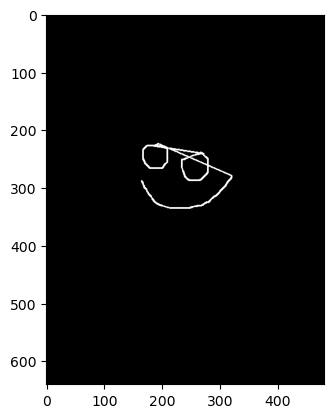

In [31]:
plt.imshow(canvas, "gray")

**`Note:`** The straight lines are due to drawing with polylines. Once the left button is released the program stops collecting mouse movements. Which is all good. But the problem is when we double click at another position to start tracking again those movements are appended to the same list as before. As a result when drawing with polylines, the intermediary stops aren't recognized. To avoid this we can use the drawing function inside the callback function itself. 

### *Mouse as a paintbrush*

In [38]:
class Queue:
    def __init__(self):
        self.queue = []

    def enqueue(self, item):
        return self.queue.append(item)

    def dequeue(self):
        return None if len(self.queue) == 0 else self.queue.pop(0)

    def read(self):
        return None if len(self.queue) == 0 else self.queue[0]

In [48]:
def paint(event, x, y, flags, userdata):
    # a global variable that stores whether the left button was double clicked, a global variable for storing
    # whether left button is still clicked down, and another for initiating Queue which will store points
    # over which the mouse was dragged.
    # The "pts" is declared as a global variable. Otherwise it wouldn't be accessible outside of the pass
    # where it was initiated and would've thrown a "local variable not accessible" error.
    global is_left_double_clicked, is_left_down, pts

    if event == cv.EVENT_LBUTTONDBLCLK:
        # an array to capture all the points over which the mouse left button was dragged
        # it is initialized when the left button is double clicked
        pts = Queue()
        print(f"Left button double clicked at: {(x, y)}")
        is_left_double_clicked = True
        is_left_down = True

    if is_left_double_clicked and event == cv.EVENT_LBUTTONUP:
        print(f"Left button double click released at: {(x, y)}")
        is_left_down = False
        is_left_double_clicked = False

    if is_left_down and event == cv.EVENT_MOUSEMOVE:
        if pts.read() is None:
            pts.enqueue((x, y))

        else:
            previous_point = pts.dequeue()
            latest_point = (x, y)
            pts.enqueue(latest_point)
            # print(pts.read())
            cv.line(img, previous_point, latest_point, 255, 3)

In [50]:
# initialize global variables
is_left_double_clicked = False
is_left_down = False

# create window that will be bound to the getMouseCallback
img = np.zeros((300, 600), dtype=np.uint8)

# bind getMouseCallback to a named window
cv.namedWindow("Image")
cv.setMouseCallback("Image", paint)

while True:
    cv.imshow("Image", img)

    keyboad_input = cv.waitKey(100)

    # press "q" or "Esc" to quit
    if keyboad_input == ord("q"):
        break

cv.destroyAllWindows()

Left button double clicked at: (176, 117)
Left button double click released at: (176, 117)
Left button double clicked at: (176, 117)
Left button double click released at: (394, 102)
Left button double clicked at: (232, 41)
Left button double click released at: (230, 42)
Left button double clicked at: (320, 49)
Left button double click released at: (317, 47)
Left button double clicked at: (235, 98)
Left button double click released at: (235, 101)
Left button double clicked at: (279, 66)
Left button double click released at: (289, 83)
Left button double clicked at: (176, 119)
Left button double click released at: (396, 112)
Left button double clicked at: (397, 59)
Left button double click released at: (398, 86)
Left button double clicked at: (187, 61)
Left button double click released at: (188, 93)
Left button double clicked at: (417, 158)
Left button double click released at: (423, 211)
Left button double clicked at: (453, 157)
Left button double click released at: (455, 210)
Left butto

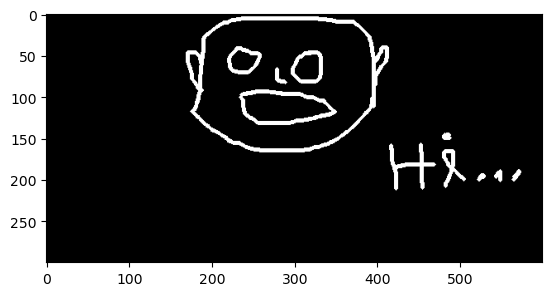

In [52]:
plt.imshow(img, "gray")